In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [4]:
path_shp_cat = r'G:\OneDrive - Ingenio Azucarero Guabira S.A\INFORMACION GENERAL\CATASTRO\NUEVO\catastro_S06_SABADO.shp'
gdf_cat = gpd.read_file(path_shp_cat)
gdf_prop = gdf_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'geometry']]

In [5]:
gdf_prop.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry
0,287.0,ARCO IRIS NORTE III--MONASTERIO,8829.0,MONASTERIO FOIANINI SYLVIA D.,L2.1,9.891023,"POLYGON ((473961.095 8075944.601, 473970.716 8..."
1,376.0,NARANJAL--AGUILERA SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L2,10.722511,"POLYGON ((480489.148 8077720.927, 480463.927 8..."
2,376.0,NARANJAL--AGUILERA SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L3,12.056506,"POLYGON ((480339.263 8078320.173, 480618.195 8..."


In [34]:
def generar_plano_pulv(shp_prop, shp_lotes, path_tif, path_out):
    # Cargar la imagen TIFF con rasterio
    with rasterio.open(path_tif) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
        img = src.read([1, 2, 3])  # Leer las bandas RGB
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='blue', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_lotes.plot(ax=ax, edgecolor='yellow', facecolor=(0, 0, 0, 0), linewidth=1)

    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))

    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])

    # 🔹 **Agregar Leyenda**
    legend_elements = [
        #facecolor=(R, G, B, Alpha)
        Patch(facecolor=(0, 0, 0, 0), edgecolor='blue', label='Lotes de propiedad'),
        # Líneas (Caminos, canales, etc.)
        Line2D([0], [0], color='yellow', linewidth=1, linestyle="-", label='Lotes para aplicar'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Guardar plano
    fig.savefig(path_plano, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


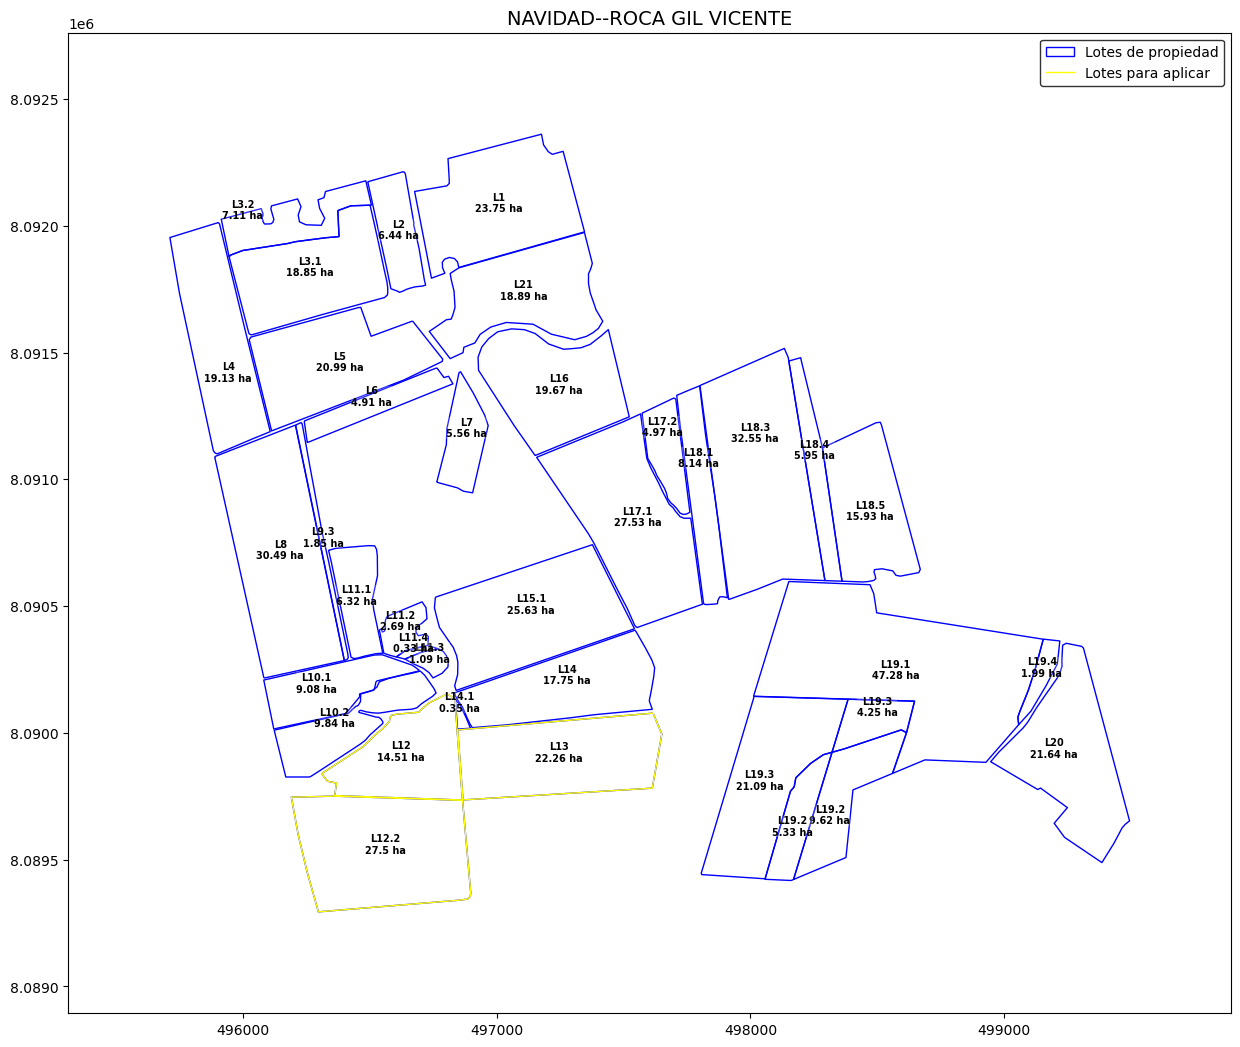

In [36]:
path_shp_lote = r"G:\BISMARK\_TEMP\VICENTE.shp"
shp_lotes = gpd.read_file(path_shp_lote)
lotes = shp_lotes[shp_lotes['unidad_01']==31]

#path_tif = r"C:\Users\bismarksr\Downloads\Imagen_Real_RGB.tif"
path_tif = r"C:\Users\Usuario\Downloads\Imagen_Real_RGB.tif"
path_plano = r"C:\Users\Usuario\Downloads\plano_30.jpg"

prop = gdf_cat[gdf_cat['unidad_01']==31]
generar_plano_pulv(prop, lotes, path_tif, path_plano)